In [58]:
# ===================================================================
#  Library
# ===================================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.simplefilter("ignore")

from tqdm.auto import tqdm

import unicodedata

import lightgbm as lgb

In [59]:
# ===================================================================
#  CFG
# ===================================================================
class CFG:
    #seed = 42
    #seed = 2023
    seed = 1111
    n_splits = 10
    data_dir = "G:/マイドライブ/signate_StudentCup2023/data/"
    target_bins = 10
    year_bins = 10
    num_boost_round = 10000
    stopping_rounds = 1500
    n_trials = 1500
    save_dir = "G:/マイドライブ/signate_StudentCup2023/exp/"
    common_features_1 = ['year_map', "fuel", "condition", "manufacturer"]
    common_features_2 = ['year_map', "fuel", "condition"]
    common_features_3 = ['year_map', "fuel"]

In [60]:
# ===================================================================
#  Utils
# ===================================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(CFG.seed)
    

def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100

In [61]:
# ===================================================================
#  Data Loading
# ===================================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)

In [62]:
# ===================================================================
#  preprocessing
# ===================================================================
# year
def pre_year(df: pd.DataFrame):
    year_dict = {
        2999:1999,
        3008:2008,
        3015:2015,
        3017:2017,
        3011:2011,
        3019:2019,
    }
    df["year"] = df["year"].replace(year_dict)
    return df
all_data = pre_year(all_data)


# manufacturer
all_data["manufacturer"] = all_data["manufacturer"].str.lower().apply(lambda x: unicodedata.normalize('NFKC', x))


# fuel
all_data["fuel"].fillna(value=-1, inplace=True)


# size
def pre_size(df: pd.DataFrame):
    size_dict = {
        "fullーsize":"full-size",
        "midーsize":"mid-size",
        "subーcompact":"sub-compact",
        "full−size":"full-size",
        "mid−size":"mid-size"
    }
    df["size"] = df["size"].replace(size_dict)
    return df
all_data = pre_size(all_data)


# title_status
all_data["title_status"].fillna(value=-1, inplace=True)


# type
all_data["type"].fillna(value=-1, inplace=True)


# state
all_data["state"].fillna(value=-1, inplace=True)

In [63]:
# ===================================================================
#  use features
# =================================================================== 

## numerical
CFG.numerical_features = ['year','odometer',"odometer_per_year", "year_map"]


## category
CFG.categorical_features = ['region', 'condition', 'cylinders', 'title_status', 'transmission', 'drive', "size", 'type','paint_color', 'state', 'manufacturer', 'fuel',]

CFG.target_encoding_features = []
#CFG.target_encoding_features = ['region', 'condition', 'cylinders', 'title_status', 'transmission', 'drive', "size", 'type','paint_color', 'state', 'manufacturer', 'fuel',]

CFG.count_encoding_features = ['region']
#CFG.count_encoding_features = ['region', 'condition', 'cylinders', 'title_status', 'transmission', 'drive', "size", 'type','paint_color', 'state', 'manufacturer', 'fuel',]


## use_features
CFG.use_features = list(set(CFG.numerical_features) | set(CFG.categorical_features))

In [64]:

# ===================================================================
#  train test split
# ===================================================================
train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)

train.sort_values(by="id", ignore_index=True, inplace=True)

train["year_map"], bins = pd.cut(train["year"], bins=CFG.year_bins, labels=False, retbins=True)
test["year_map"] = pd.cut(test["year"], bins=bins, labels=False)
train["price_map"] = pd.cut(train["price"], bins=CFG.target_bins, labels=False)


skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val) in enumerate(skf.split(X=train, y=train["price_map"])):
    train.loc[val, "fold"] = i
print(train["fold"].value_counts())
print(train.groupby("fold")["price"].mean().std())

0.0    2754
1.0    2754
7.0    2753
2.0    2753
4.0    2753
9.0    2753
6.0    2753
8.0    2753
5.0    2753
3.0    2753
Name: fold, dtype: int64
40.708439677834924


In [65]:
# ===================================================================
#  Variance by category
# ===================================================================
df = train[(train["odometer"] > 100)&(train["odometer"] < 400000)].reset_index(drop=True)
tmp = []
for col in CFG.categorical_features+["year_map"]:
    tmp.append(df.groupby(col)["odometer"].mean().std())
df = pd.DataFrame(zip(CFG.categorical_features+["year_map"], tmp, [len(train[col].unique()) for col in CFG.categorical_features+["year_map"]]), columns=["feature", "std", "len"],)
display(df.sort_values("std", ascending=False, ignore_index=True))


tmp = []
for col in CFG.categorical_features+["year_map"]:
    tmp.append(train.groupby(col)["price"].mean().std())
df = pd.DataFrame(zip(CFG.categorical_features+["year_map"], tmp, [len(train[col].unique()) for col in CFG.categorical_features+["year_map"]]), columns=["feature", "std", "len"],)
display(df.sort_values("std", ascending=False, ignore_index=True))

,feature,std,len
0,year_map,31781.158448,10
1,fuel,29617.927026,6
2,condition,26189.870015,6
3,manufacturer,23019.170311,46
4,region,21126.085990,372
5,type,18606.445907,14
6,paint_color,17499.838479,12
7,drive,13320.597407,3
8,title_status,12292.031506,7
9,cylinders,12220.892044,8


,feature,std,len
0,fuel,5413.273688,6
1,year_map,5394.883994,10
2,manufacturer,5143.337572,46
3,drive,4516.169195,3
4,condition,3999.853493,6
5,region,3598.950969,372
6,type,3539.821715,14
7,size,2866.425386,4
8,cylinders,2820.953658,8
9,title_status,2485.028366,7


In [66]:
# ===================================================================
#  model
# ===================================================================
preds, oof_df, feature_importance_df = [], pd.DataFrame(), pd.DataFrame()
for fold in range(CFG.n_splits):
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_valid = train[train["fold"] == fold].reset_index(drop=True)
    test_df = test.copy()

    # fix odometer
    def fix_odometer(df, df_original, keys_1, keys_2, keys_3, grouped_means_1, grouped_means_2, grouped_means_3,):
        #print(df.shape)
        for id_ in df["id"]:
            tmp_1 = tuple(df[df["id"] == id_][CFG.common_features_1].values.tolist()[0])
            tmp_2 = tuple(df[df["id"] == id_][CFG.common_features_2].values.tolist()[0])
            tmp_3 = tuple(df[df["id"] == id_][CFG.common_features_3].values.tolist()[0])
            
            if tmp_1 in keys_1:
                df_original.loc[df_original["id"] == id_, "odometer"] = grouped_means_1[tmp_1]
            elif tmp_2 in keys_2:
                df_original.loc[df_original["id"] == id_, "odometer"] = grouped_means_2[tmp_2]
            elif tmp_3 in keys_3:
                df_original.loc[df_original["id"] == id_, "odometer"] = grouped_means_3[tmp_3]    
            else:
                raise ValueError("")
            
            return df_original

    ## 補完するデータたち
    right_df = X_train[(X_train["odometer"] > 100)&(X_train["odometer"] < 400000)].reset_index(drop=True)
    grouped_means_1 = right_df.groupby(CFG.common_features_1)["odometer"].mean().to_dict()
    grouped_means_2 = right_df.groupby(CFG.common_features_2)["odometer"].mean().to_dict()
    grouped_means_3 = right_df.groupby(CFG.common_features_3)["odometer"].mean().to_dict()


    ## 共通点の多いデータで補完する
    keys_1 = tuple([k for k, _ in grouped_means_1.items()])
    keys_2 = tuple([k for k, _ in grouped_means_2.items()])
    keys_3 = tuple([k for k, _ in grouped_means_3.items()])

    X_train = fix_odometer(X_train[(X_train["odometer"] < 100)|(X_train["odometer"] > 400000)].reset_index(drop=True), X_train,
                           keys_1, keys_2, keys_3, grouped_means_1, grouped_means_2, grouped_means_3)


    X_valid = fix_odometer(X_valid[(X_valid["odometer"] < 100)|(X_valid["odometer"] > 400000)].reset_index(drop=True), X_valid,
                           keys_1, keys_2, keys_3, grouped_means_1, grouped_means_2, grouped_means_3)


    test_df = fix_odometer(test_df[(test_df["odometer"] < 100)|(test_df["odometer"] > 400000)].reset_index(drop=True), test_df,
                           keys_1, keys_2, keys_3, grouped_means_1, grouped_means_2, grouped_means_3)
    
    
    display(X_train["odometer"].describe())
    display(X_valid["odometer"].describe())
    display(test_df["odometer"].describe())
    
    # feature_engineering
    def add_odometer_per_year(df: pd.DataFrame):
        df["elapsed_years"] = 2023 - df["year"]
        df["odometer_per_year"] = df["odometer"] / df["elapsed_years"]
        return df
    X_train = add_odometer_per_year(X_train)
    X_valid = add_odometer_per_year(X_valid)
    test_df = add_odometer_per_year(test_df)
    
    
    # CFG.target_encoding_features
    for col in CFG.target_encoding_features:
        mean_map = X_train.groupby(col)["price"].mean()
        X_train[col+"_target_encoding"] = X_train[col].map(mean_map)
        X_valid[col+"_target_encoding"] = X_valid[col].map(mean_map)
        test_df[col+"_target_encoding"] = test_df[col].map(mean_map)
        if fold == 0:
            CFG.use_features.append(col+"_target_encoding")
            
        
    # CFG.count_encoding_features
    for col in CFG.count_encoding_features:
        count_map = X_train[col].value_counts().to_dict()
        X_train[col+"_count_encoding"] = X_train[col].map(count_map)
        X_valid[col+"_count_encoding"] = X_valid[col].map(count_map)
        test_df[col+"_count_encoding"] = test_df[col].map(count_map)
        if fold == 0:
            CFG.use_features.append(col+"_count_encoding")
    
    
    
    # CFG.categorical_featuresをcategory型に変換
    for col in CFG.categorical_features:
        X_train[col] = X_train[col].astype("category")
        X_valid[col] = X_valid[col].astype("category")
        test_df[col] = test_df[col].astype("category")
        
            
                
    # params
    lgb_param = {
        "objective": "mape",
        "metric": 'mape',
        "verbosity": -1,
        "seed" : CFG.seed,
    }


    # train
    lgb_train = lgb.Dataset(X_train[CFG.use_features], X_train["price"], categorical_feature = CFG.categorical_features,)
    lgb_valid = lgb.Dataset(X_valid[CFG.use_features], X_valid["price"], categorical_feature = CFG.categorical_features,)

    model = lgb.train(
                    lgb_param, 
                    lgb_train, 
                    num_boost_round=CFG.num_boost_round, 
                    valid_sets=[lgb_valid],
                    categorical_feature = CFG.categorical_features,
                    callbacks=[lgb.early_stopping(stopping_rounds=CFG.stopping_rounds, verbose=False),],
                    )

    # feature importance
    feature_importance_df[f"importance_fold{fold}"] = model.feature_importance(importance_type='gain')

    # eval
    X_valid[f"pred"] = model.predict(X_valid[CFG.use_features], num_iteration=model.best_iteration)
    print(f"fold{fold}:", get_score(y_true=X_valid["price"], y_pred=X_valid["pred"]))

    # concat
    oof_df = pd.concat([oof_df, X_valid], ignore_index=True)

    # pred test
    preds.append(model.predict(test_df[CFG.use_features]))
    
feature_importance_df["feature"] = CFG.use_features
print('\033[32m'+"====== CV score ======"+'\033[0m')
print('\033[32m'+f'{get_score(oof_df["price"], oof_df["pred"])}'+'\033[0m')
predictions = np.mean(preds, axis=0)

count    2.477800e+04
mean     1.160462e+05
std      6.471141e+04
min     -1.318690e+05
25%      7.826600e+04
50%      1.113575e+05
75%      1.507405e+05
max      2.946000e+06
Name: odometer, dtype: float64

count    2.754000e+03
mean     1.158784e+05
std      6.267575e+04
min     -1.000000e+00
25%      7.910700e+04
50%      1.124830e+05
75%      1.516958e+05
max      1.187840e+06
Name: odometer, dtype: float64

count     27537.000000
mean     116599.656821
std       59038.369305
min          -1.000000
25%       79915.000000
50%      112443.000000
75%      150380.000000
max      394595.000000
Name: odometer, dtype: float64

KeyboardInterrupt: 

seed42:45.69067241147953  
seed2023:45.624254326248    
seed1111:45.65378092791193   

In [ ]:
CFG.use_features

['year',
 'transmission',
 'state',
 'paint_color',
 'drive',
 'title_status',
 'condition',
 'odometer',
 'manufacturer',
 'year_map',
 'fuel',
 'region',
 'type',
 'cylinders',
 'size',
 'odometer_per_year',
 'region_count_encoding']

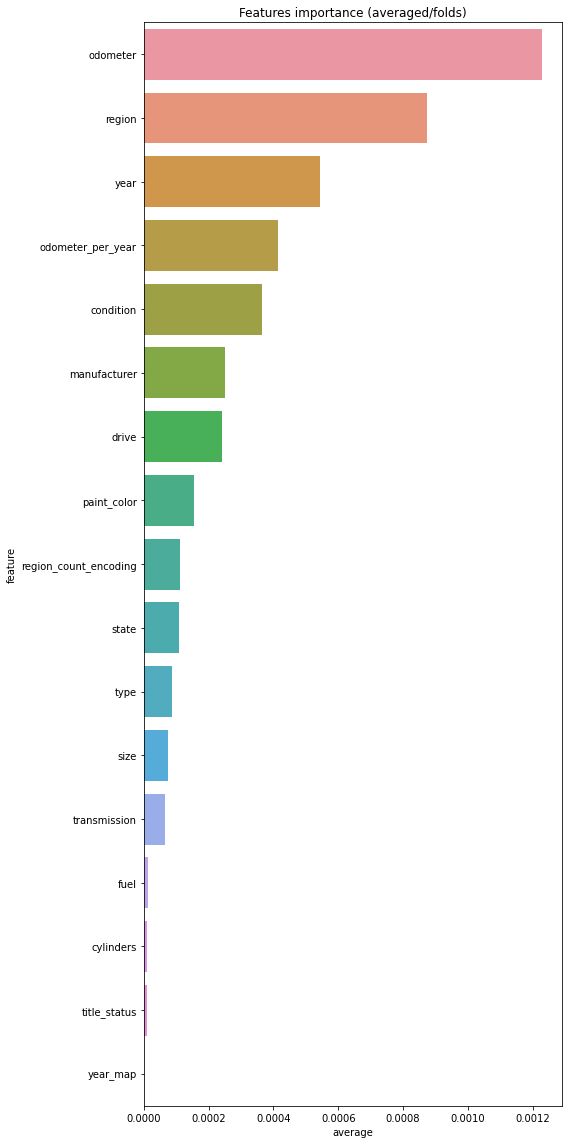

In [ ]:
# ===================================================================
#  plot feature importance
# ===================================================================
feature_importance_df.fillna(value=0, inplace=True)
feature_importance_df["average"] = feature_importance_df.loc[:, 'importance_fold0':f'importance_fold{CFG.n_splits-1}'].mean(axis=1)
best_features = feature_importance_df[["feature", "average"]].groupby("feature", as_index=False).mean().sort_values(by="average", ascending=False).head(50)
plt.figure(figsize=(8, 16))
sns.barplot(x="average", y="feature", data=best_features)
plt.title('Features importance (averaged/folds)')
plt.tight_layout()